In [2]:
# IMPORTS
import cvxpy as cp
import numpy as np
import numpy.linalg
import numpy.matlib
from numpy.linalg import norm
import algorithms.tikhonov as tikhonov
from scipy import interpolate
from scipy import signal
import csv   
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
noise_lvl = replace(noise_lvl,'.','d')
filename = ['coef_errors_Lorenz63_',filter,'_',noise_lvl];
save(filename, 'coef_error')# LOAD DATA

# 1) LOAD DYNAMICS AND TIME ARRAYS

filepath = 'data_files/Lorenz63_dynamics.csv'
dynamics = np.genfromtxt(filepath, delimiter=',')

t = dynamics[0]
data = dynamics[1:]
n_states = int(data.shape[0] / 2)
X = data[0:n_states]
DX = data[n_states:]
t_samples = len(t)


# 2) LOAD OBSERVATION SAMPLES
Y_samples = []
noise_lvl = '1'

for state in range(n_states):
    
    filepath = 'data_files/Lorenz63_samples_noise_' + noise_lvl +'_Y'+ str(state+1) + '.csv'
    y = np.genfromtxt(filepath, delimiter=',')
        
    Y_samples.append(y)
    
n_samples = Y_samples[0].shape[0]

  Convergence criterion reached in 20 iterations.
  Convergence criterion reached in 20 iterations.
  Convergence criterion reached in 19 iterations.


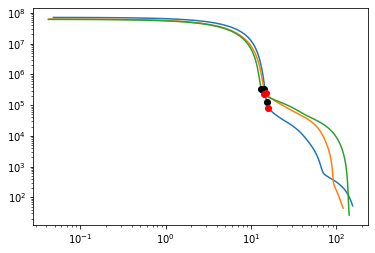

In [4]:
################### DENOISING AND NUMERICAL DIFFERENTIATION - SMOOTHING SPLINES ###################
# Yhat_tik = np.zeros((t_samples, n_states))
# DYhat_tik = np.zeros((t_samples, n_states))
error_X = np.zeros((n_samples,n_states))
error_dX = np.zeros((n_samples,n_states))
trim = int(np.floor(5 / 100 * t_samples))


# for sample in range(n_samples):
for sample in range(1):

    #CVX code
    for state in range(n_states):
        
        y = Y_samples[state][sample,:]
        
        tik_flc = tikhonov.full_lcurve(y, t, lambda_min = 1e-16, lambda_max = 1)
        dy_path = tik_flc[0]
        res, reg = tik_flc[1]
        error_path = np.zeros(dy_path.shape[1])
        for i in range(dy_path.shape[1]):
            error_path[i] = norm(dy_path[:,i] - DX[state,:]) / norm(DX[state,:])
        
        min_indx = np.argmin(error_path)
        #Find corner point
        tik_lc = tikhonov.lcurve_corner(y, t, lambda_min = 1e-16, lambda_max = 1)
        dy_tik = tik_lc[0]
        resc, regc = tik_lc[3]
        plt.loglog(res, reg)
        plt.loglog(res[min_indx], reg[min_indx],'ko')
        plt.loglog(resc[-1], regc[-1], 'ro')
#         plt.plot(t, dy_path[:,min_indx])
#         plt.plot(t, DX[state,:],'k--')
        #Remove ends
        DYhat_tik = dy_tik[trim:-trim]
        #Compute errors
        error_dX[sample,state] = norm(DYhat_tik - DX[state,trim:-trim]) / norm(DX[state,trim:-trim])

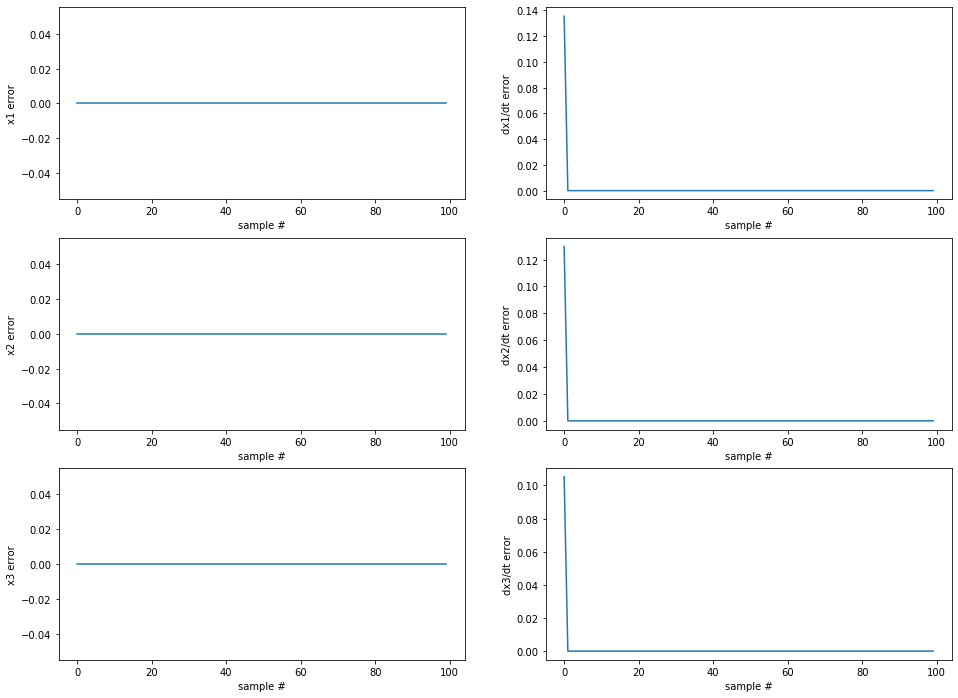

In [5]:
fig, ax = plt.subplots(n_states,2, figsize = (16,12))

for state in range(n_states):
    ax[state][0].plot(error_X[:,state])
    ax[state][0].set_ylabel(f'x{state+1} error')
    ax[state][0].set_xlabel('sample #')
    ax[state][1].plot(error_dX[:,state])
    ax[state][1].set_ylabel(f'dx{state+1}/dt error')
    ax[state][1].set_xlabel('sample #')

In [6]:
mean_X_error = np.zeros(n_states)
mean_dX_error = np.zeros(n_states)

var_X_error = np.zeros(n_states)
var_dX_error = np.zeros(n_states)

ind_names = []
col_names = ['mean error x', 'var. error x', 'mean error dx', 'var. error dx']

for state in range(n_states):
    mean_X_error[state] = error_X[:,state].mean()
    mean_dX_error[state] = error_dX[:,state].mean()
    var_X_error[state] = error_X[:,state].var()
    var_dX_error[state] = error_dX[:,state].var()
    ind_names.extend(['state x' + str(state+1)])
    

In [7]:
errors = pd.DataFrame(np.array([mean_X_error, var_X_error, mean_dX_error, var_dX_error]).T, index = ind_names, columns=col_names)
errors

,mean error x,var. error x,mean error dx,var. error dx
state x1,0.0,0.0,0.001354,0.000181
state x2,0.0,0.0,0.001298,0.000167
state x3,0.0,0.0,0.001053,0.000110
